Analisis estado ganaderias OK 

In [1]:
import os
import pandas as pd
from pathlib import Path

# 1️⃣ Ruta a la carpeta "data" (sube un nivel desde notebooks y entra en data)
base_path = Path.cwd().parent / "data/data_comparativa"

# 2️⃣ Buscar todos los archivos CSV dentro de la carpeta (también comprimidos .gz)
csv_files = []
for pattern in ("*.csv", "*.csv.gz"):
    csv_files.extend(base_path.glob(pattern))

if not csv_files:
    raise FileNotFoundError(f"No se encontraron archivos CSV en {base_path}")

# 3️⃣ Seleccionar el CSV más reciente por fecha de modificación
latest_csv = max(csv_files, key=os.path.getmtime)
print(f"📂 Cargando archivo más reciente: {latest_csv.name}")

# 4️⃣ Cargarlo en Pandas (compression se infiere por extensión)
df = pd.read_csv(latest_csv, low_memory=False)

# 5️⃣ Vista rápida de datos
print(f"✅ Archivo cargado con {df.shape[0]:,} filas y {df.shape[1]} columnas.")
print(df.head())


📂 Cargando archivo más reciente: data-27-08-2025.csv
✅ Archivo cargado con 9,127 filas y 42 columnas.
                              device_id  ...  Ganadería OK (>70% dispositivos OK)
0  643f7f42-1d44-4a2d-944e-eddd5d5e7182  ...                                False
1  e14b71c0-5436-4442-b25a-137172011c33  ...                                False
2  7d639252-0d54-4d0e-a928-da2f22aaa3ae  ...                                False
3  dce17e04-1913-41b1-96e2-a5deb9fa0e75  ...                                False
4  62c88758-64fd-4ea1-9054-2da2a17a8353  ...                                False

[5 rows x 42 columns]


In [2]:
import pandas as pd

# Crear DataFrame con índice, nombre y tipo de dato
cols_info = pd.DataFrame({
    "indice": range(len(df.columns)),
    "columna": df.columns,
    "tipo_dato": df.dtypes.astype(str)
})

display(cols_info)

,indice,columna,tipo_dato
device_id,0,device_id,object
SerialNumber,1,SerialNumber,int64
Model,2,Model,object
mensajes_esperados,3,mensajes_esperados,int64
mensajes_recibidos,4,mensajes_recibidos,int64
mensajes_sin_gps,5,mensajes_sin_gps,int64
pct_recibidos_vs_esperados,6,pct_recibidos_vs_esperados,float64
pct_sin_gps_vs_esperados,7,pct_sin_gps_vs_esperados,float64
pct_sin_gps_recibidos,8,pct_sin_gps_recibidos,float64
ultimo_mensaje_recibido,9,ultimo_mensaje_recibido,object


In [3]:
import pandas as pd
import numpy as np

# --- util: división segura (evita /0) ---
def pct(num, den):
    num = num.astype(float)
    den = den.astype(float)
    return np.where(den > 0, (num / den) * 100.0, np.nan)

# =========================
# 1) Flag OK a nivel DISPOSITIVO (≥60%)
#    Define/actualiza la columna booleana por dispositivo según % válidas vs esperadas
# =========================
ok_col = "Dispositivo OK (≥60% válidas vs esperadas)"

# Si existen las columnas necesarias, lo calculamos; si no, respetamos lo que ya venga en df[ok_col] (si existe)
if {"Posición GPS válida (n)", "Mensajes esperados (detallado)"}.issubset(df.columns):
    den = df["Mensajes esperados (detallado)"].astype(float)
    num = df["Posición GPS válida (n)"].astype(float)
    pct_valid_vs_expected = np.where(den > 0, (num / den) * 100.0, np.nan)
    df[ok_col] = np.where(~np.isnan(pct_valid_vs_expected), pct_valid_vs_expected >= 60.0, False)
else:
    # Si no tenemos las columnas para calcular, aseguramos booleana sin NaN (por si ya existía)
    if ok_col in df.columns:
        df[ok_col] = df[ok_col].fillna(False).astype(bool)
    else:
        # Crea la columna a False si no se puede calcular
        df[ok_col] = False

# Asegura booleanos sin NaN
df[ok_col] = df[ok_col].fillna(False).astype(bool)

# =========================
# 2) Agregados por GANADERÍA
# =========================
agr_cols = {
    "device_id": "nunique",
    "Mensajes esperados (detallado)": "sum",
    "Mensajes recibidos (n)": "sum",
    "Mensaje con posición GPS (n)": "sum",
    "Posición GPS válida (n)": "sum",
    "Baja precisión (n)": "sum",
    "Posición GPS no válida (n)": "sum",
    "No válida por calidad GPS (n)": "sum",
    "No válida por filtro velocidad (n)": "sum",
    ok_col: "sum",  # cuenta cuántos dispositivos están OK
}

# Filtra solo las columnas que existan para evitar errores en entornos con columnas faltantes
agr_cols = {k: v for k, v in agr_cols.items() if (k == ok_col) or (k in df.columns)}

agg = (
    df.groupby("ranch_name", dropna=False)
      .agg(agr_cols)
      .rename(columns={
          "device_id": "n_dispositivos",
          ok_col: "dispositivos_ok",
      })
      .reset_index()
)

# Asegura que las columnas clave existan aunque falten en el origen
for needed in ["n_dispositivos", "dispositivos_ok"]:
    if needed not in agg.columns:
        agg[needed] = 0

# =========================
# 3) Porcentajes de calidad a nivel GANADERÍA
# =========================
def add_pct(target_df, num_col, den_col, out_col):
    if num_col in target_df.columns and den_col in target_df.columns:
        target_df[out_col] = pct(target_df[num_col], target_df[den_col])
    return target_df

agg = add_pct(agg, "Mensajes recibidos (n)",           "Mensajes esperados (detallado)", "Mensajes recibidos (%)")
agg = add_pct(agg, "Mensaje con posición GPS (n)",     "Mensajes recibidos (n)",         "Mensaje con posición GPS (%)")
agg = add_pct(agg, "Posición GPS válida (n)",          "Mensajes recibidos (n)",         "Posición GPS válida (%)")
agg = add_pct(agg, "Baja precisión (n)",               "Posición GPS válida (n)",        "Baja precisión (%)")
agg = add_pct(agg, "Posición GPS no válida (n)",       "Mensajes recibidos (n)",         "Posición GPS no válida (%)")
agg = add_pct(agg, "No válida por calidad GPS (n)",    "Posición GPS no válida (n)",     "No válida por calidad GPS (%)")
agg = add_pct(agg, "No válida por filtro velocidad (n)","Posición GPS no válida (n)",    "No válida por filtro velocidad (%)")

# % de dispositivos OK en ganadería y flag global de ganadería OK (≥70%)
agg["% dispositivos OK en ganadería"] = pct(agg["dispositivos_ok"].astype(float), agg["n_dispositivos"].astype(float))
agg["Ganadería OK (≥70% dispositivos OK)"] = (agg["% dispositivos OK en ganadería"] >= 70.0)

# =========================
# 4) Orden de columnas “bonito” (solo las que existan)
# =========================
cols = [
    "ranch_name", "n_dispositivos", "dispositivos_ok", "% dispositivos OK en ganadería",
    "Ganadería OK (≥70% dispositivos OK)",
    "Mensajes esperados (detallado)", "Mensajes recibidos (n)", "Mensajes recibidos (%)",
    "Mensaje con posición GPS (n)", "Mensaje con posición GPS (%)",
    "Posición GPS válida (n)", "Posición GPS válida (%)",
    "Baja precisión (n)", "Baja precisión (%)",
    "Posición GPS no válida (n)", "Posición GPS no válida (%)",
    "No válida por calidad GPS (n)", "No válida por calidad GPS (%)",
    "No válida por filtro velocidad (n)", "No válida por filtro velocidad (%)",
]
cols = [c for c in cols if c in agg.columns]

df_ganaderias = agg[cols].sort_values("% dispositivos OK en ganadería", ascending=False, na_position="last")


In [5]:
import pandas as pd
import numpy as np

# Columnas que ya tienes en df
OK_COL = "Dispositivo OK (>60% válidas vs esperadas)"
SCORE_COL = "Posición válida vs esperadas (%)"

# --- 1) Normalización y deduplicación a nivel DISPOSITIVO ---
# (por si el join con Animals duplicó filas)
cols_min = ["device_id", "ranch_name", "Model", OK_COL, SCORE_COL]
cols_min = [c for c in cols_min if c in df.columns]

df_dev = (
    df[cols_min]
    .drop_duplicates(subset=["device_id"])
    .copy()
)

# Asegura booleano y numérico
df_dev[OK_COL] = df_dev[OK_COL].fillna(False).astype(bool)
df_dev[SCORE_COL] = pd.to_numeric(df_dev[SCORE_COL], errors="coerce")

# --- 2) Estadística general de % dispositivos OK ---
n_devices = df_dev["device_id"].nunique()
ok_count = int(df_dev[OK_COL].sum())
pct_ok = (ok_count / n_devices * 100) if n_devices > 0 else np.nan
no_ok = n_devices - ok_count
pct_no_ok = (100 - pct_ok) if pd.notnull(pct_ok) else np.nan

stats_general = pd.DataFrame({
    "n_dispositivos": [n_devices],
    "dispositivos_ok": [ok_count],
    "% dispositivos_ok": [round(pct_ok, 2)],
    "dispositivos_no_ok": [no_ok],
    "% no_ok": [round(pct_no_ok, 2)],
    "umbral_ok_%": [60.0],
})

print("=== Estadística general de dispositivos OK ===")
print(stats_general.to_string(index=False))

# --- 3) Percentiles del indicador por dispositivo ---
valid_scores = df_dev[SCORE_COL].dropna()
percentiles_general = (
    valid_scores.quantile([0.1, 0.25, 0.5, 0.75, 0.9])
    .rename(index={0.1: "p10", 0.25: "p25", 0.5: "p50", 0.75: "p75", 0.9: "p90"})
    .round(2)
    .to_frame(name=SCORE_COL)
)

print("\n=== Percentiles del % válidas vs esperadas (por dispositivo) ===")
print(percentiles_general.to_string())

# --- 4) Distribución por tramos del % de válidas vs esperadas ---
# Nota: puede haber >100% si hay más válidas que esperadas
bins = [-1, 0, 20, 40, 60, 80, 100, 120, np.inf]
labels = ["<=0", "0-20", "20-40", "40-60", "60-80", "80-100", "100-120", ">120"]

distrib_score = (
    df_dev.assign(bucket=pd.cut(df_dev[SCORE_COL], bins=bins, labels=labels, include_lowest=True))
         .groupby("bucket", dropna=False)
         .size()
         .rename("n")
         .reset_index()
)

if n_devices > 0:
    distrib_score["%"] = (distrib_score["n"] / n_devices * 100).round(2)

print("\n=== Distribución del % de válidas vs esperadas (por tramos) ===")
print(distrib_score.fillna({"bucket": "NaN/No disponible"}).to_string(index=False))

# --- 5) (Opcional) Ranking por ganadería y modelo ---
if {"ranch_name", OK_COL}.issubset(df_dev.columns):
    ranch_rank = (
        df_dev.groupby("ranch_name")[OK_COL]
              .agg(n_dispositivos="count", dispositivos_ok="sum")
              .assign(**{
                  "% dispositivos_ok": lambda d: (d["dispositivos_ok"] / d["n_dispositivos"] * 100).round(2)
              })
              .sort_values("% dispositivos_ok", ascending=False)
              .reset_index()
    )
    print("\n=== Ranking ganaderías por % dispositivos OK ===")
    print(ranch_rank.head(10).to_string(index=False))

if {"Model", OK_COL}.issubset(df_dev.columns):
    model_rank = (
        df_dev.groupby("Model")[OK_COL]
              .agg(n_dispositivos="count", dispositivos_ok="sum")
              .assign(**{
                  "% dispositivos_ok": lambda d: (d["dispositivos_ok"] / d["n_dispositivos"] * 100).round(2)
              })
              .sort_values("% dispositivos_ok", ascending=False)
              .reset_index()
    )
    print("\n=== Ranking modelos por % dispositivos OK ===")
    print(model_rank.to_string(index=False))


=== Estadística general de dispositivos OK ===
 n_dispositivos  dispositivos_ok  % dispositivos_ok  dispositivos_no_ok  % no_ok  umbral_ok_%
           9141             4163              45.54                4978    54.46         60.0

=== Percentiles del % válidas vs esperadas (por dispositivo) ===
     Posición válida vs esperadas (%)
p10                              0.00
p25                              0.00
p50                             50.00
p75                             88.89
p90                            102.78

=== Distribución del % de válidas vs esperadas (por tramos) ===


<positron-console-cell-5>:61: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


TypeError: Cannot setitem on a Categorical with a new category (NaN/No disponible), set the categories first

=== Resumen global ===
Ganaderías totales: 488
Ganaderías OK (> 70% dispositivos OK): 146  (29.92%)
Dispositivos totales activos: 9141
Dispositivos OK (>60% válidas vs esperadas): 4164  (45.55%)
-
[OK] Gráfica guardada en: ganaderias_hist_categorizado.png


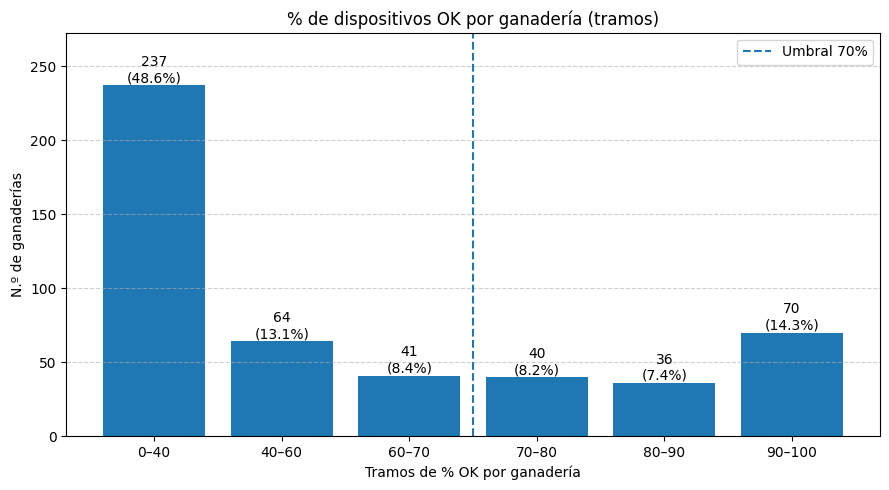

In [6]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---------------------- Config ----------------------
OK_RANCH_COL   = "Ganadería OK (>70% dispositivos OK)"
OK_DEVICE_COL  = "Dispositivo OK (>60% válidas vs esperadas)"
PCT_RANCH_COL  = "% dispositivos OK en ganadería"
THRESHOLD = 70.0                 # umbral de ganadería
OUT_DIR = Path(".")              # carpeta de salida para la imagen
OUT_FILE = OUT_DIR / "ganaderias_hist_categorizado.png"

# Tramos para “histograma categorizado” (puedes cambiarlos si quieres)
BINS  = [0, 40, 60, 70, 80, 90, 100]
LABELS = ["0–40", "40–60", "60–70", "70–80", "80–90", "90–100"]

# ------------------ Helpers principales ------------------
def ensure_df_ganaderias(df=None):
    """
    Devuelve df_ganaderias con columnas:
      - ranch_name
      - n_dispositivos
      - dispositivos_ok
      - "% dispositivos OK en ganadería"
      - "Ganadería OK (>70% dispositivos OK)" (según THRESHOLD)
    Si df_ganaderias ya existe en globales, lo usa y completa columnas que falten.
    Si no existe, lo construye desde df (una fila por device_id).
    """
    g = globals()
    if "df_ganaderias" in g:
        dfg = g["df_ganaderias"].copy()
        # Asegurar % y flag OK
        if PCT_RANCH_COL not in dfg.columns:
            raise KeyError(f"df_ganaderias no tiene la columna '{PCT_RANCH_COL}'.")
        if OK_RANCH_COL not in dfg.columns:
            dfg[OK_RANCH_COL] = dfg[PCT_RANCH_COL] > THRESHOLD
        # Si faltan n_dispositivos/dispositivos_ok y tenemos df base, los calculamos
        if (("n_dispositivos" not in dfg.columns) or ("dispositivos_ok" not in dfg.columns)) and ("df" in g):
            base = g["df"][["device_id", "ranch_name", OK_DEVICE_COL]].drop_duplicates(subset=["device_id"]).copy()
            base[OK_DEVICE_COL] = base[OK_DEVICE_COL].fillna(False).astype(bool)
            fill = (
                base.groupby("ranch_name")[OK_DEVICE_COL]
                    .agg(n_dispositivos="count", dispositivos_ok="sum")
                    .reset_index()
            )
            dfg = dfg.merge(fill, on="ranch_name", how="left")
        return dfg

    # Si no existe df_ganaderias, necesitamos df base
    if df is None:
        if "df" not in g:
            raise NameError("No hay 'df_ganaderias' ni 'df' en el entorno.")
        df = g["df"]

    needed = {"ranch_name", "device_id", OK_DEVICE_COL}
    if not needed.issubset(df.columns):
        raise KeyError(f"El DataFrame 'df' necesita columnas: {needed}")

    base = df[["device_id", "ranch_name", OK_DEVICE_COL]].drop_duplicates(subset=["device_id"]).copy()
    base[OK_DEVICE_COL] = base[OK_DEVICE_COL].fillna(False).astype(bool)

    dfg = (
        base.groupby("ranch_name")[OK_DEVICE_COL]
            .agg(n_dispositivos="count", dispositivos_ok="sum")
            .assign(**{
                PCT_RANCH_COL: lambda d: (d["dispositivos_ok"] / d["n_dispositivos"] * 100.0)
            })
            .reset_index()
    )
    dfg[OK_RANCH_COL] = dfg[PCT_RANCH_COL] > THRESHOLD
    return dfg

def resumen_global(dfg, df_base=None):
    """
    Imprime resumen global e intenta calcular:
      - ganaderías totales / OK / %
      - dispositivos totales activos / dispositivos OK (si es posible)
    """
    total_ranch = int(dfg["ranch_name"].nunique())
    ok_ranch = int(dfg[OK_RANCH_COL].fillna(False).astype(bool).sum())
    pct_ranch_ok = (ok_ranch / total_ranch * 100.0) if total_ranch > 0 else np.nan

    # Dispositivos totales activos
    if "n_dispositivos" in dfg.columns:
        total_devices = int(dfg["n_dispositivos"].fillna(0).sum())
    elif df_base is not None and {"device_id"}.issubset(df_base.columns):
        total_devices = int(df_base["device_id"].nunique())
    else:
        total_devices = None

    # Dispositivos OK
    if "dispositivos_ok" in dfg.columns:
        devices_ok = int(dfg["dispositivos_ok"].fillna(0).sum())
    elif df_base is not None and {OK_DEVICE_COL}.issubset(df_base.columns):
        devices_ok = int(df_base.drop_duplicates("device_id")[OK_DEVICE_COL].fillna(False).sum())
    else:
        devices_ok = None

    print("=== Resumen global ===")
    print(f"Ganaderías totales: {total_ranch}")
    print(f"Ganaderías OK (> {THRESHOLD:.0f}% dispositivos OK): {ok_ranch}  ({pct_ranch_ok:.2f}%)")
    if total_devices is not None:
        if devices_ok is not None:
            pct_dev_ok = (devices_ok / total_devices * 100.0) if total_devices > 0 else np.nan
            print(f"Dispositivos totales activos: {total_devices}")
            print(f"Dispositivos OK (>60% válidas vs esperadas): {devices_ok}  ({pct_dev_ok:.2f}%)")
        else:
            print(f"Dispositivos totales activos: {total_devices}")
    print("-")

def plot_hist_categorizado(dfg, out_path: Path):
    """
    Binea el % de dispositivos OK por ganadería en tramos definidos y
    dibuja UNA ÚNICA GRÁFICA (barras) con etiquetas de conteo y % por barra.
    """
    s = dfg[PCT_RANCH_COL].dropna().astype(float)
    if s.empty:
        print("No hay datos para el histograma categorizado.")
        return None

    cats = pd.cut(s, bins=BINS, labels=LABELS, include_lowest=True, right=True)
    dist = cats.value_counts(dropna=False).reindex(LABELS, fill_value=0)
    n_total = int(dist.sum())
    pct = (dist / n_total * 100.0).round(1) if n_total > 0 else dist * np.nan

    fig, ax = plt.subplots(figsize=(9, 5))
    bars = ax.bar(dist.index.astype(str), dist.values)

    ax.set_title("% de dispositivos OK por ganadería (tramos)")
    ax.set_xlabel("Tramos de % OK por ganadería")
    ax.set_ylabel("N.º de ganaderías")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    # Etiquetas encima de cada barra: conteo (porcentaje)
    ymax = 0
    for i, b in enumerate(bars):
        h = b.get_height()
        ymax = max(ymax, h)
        ax.text(b.get_x() + b.get_width()/2, h, f"{int(h)}\n({pct.iat[i]}%)",
                ha="center", va="bottom")

    # Línea de umbral 70% → cae dentro de la categoría "70–80" (solo referencia visual)
    # Marcamos una línea vertical entre categorías (aprox. a su posición)
    if "60–70" in LABELS and "70–80" in LABELS:
        idx_70 = LABELS.index("70–80")  # borde entre 60–70 y 70–80
        ax.axvline(idx_70 - 0.5, linestyle="--", linewidth=1.5, label=f"Umbral {THRESHOLD:.0f}%")
        ax.legend()

    # Margen para que no choquen etiquetas
    ax.set_ylim(0, ymax * 1.15 if ymax > 0 else 1)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    print(f"[OK] Gráfica guardada en: {out_path}")
    return out_path

# --------------------------- RUN ---------------------------
if __name__ == "__main__":
    # Si ya tienes df_ganaderias en el entorno lo usará; si no, intentará construir desde df
    try:
        # Si quieres, pasa df explícitamente: df_ganaderias = ensure_df_ganaderias(df=tu_df)
        df_ganaderias = ensure_df_ganaderias()
    except Exception as e:
        raise

    # Resumen global (si tienes df base y quieres que estime dispositivos, pásalo como df_base=df)
    resumen_global(df_ganaderias, df_base=globals().get("df"))

    # ÚNICA gráfica: histograma categorizado con labels
    plot_hist_categorizado(df_ganaderias, OUT_FILE)


In [7]:
# ¿Cuántas ganaderías tienen 0 mensajes recibidos en 24h?
zero_mask = df_ganaderias["Mensajes recibidos (n)"] == 0
n_ganad_0 = int(zero_mask.sum())

# Listado (con n_dispositivos si lo tienes en df_ganaderias)
ganad_0 = df_ganaderias.loc[zero_mask, ["ranch_name", "n_dispositivos", "Mensajes recibidos (n)"]]

print("Ganaderías con 0 mensajes recibidos (24h):", n_ganad_0)
display(ganad_0.sort_values("n_dispositivos", ascending=False))


Ganaderías con 0 mensajes recibidos (24h): 84


,ranch_name,n_dispositivos,Mensajes recibidos (n)
354,Matías Moreno Cabrera,55,0
412,Raul Mahillo Valiente,49,0
182,Ivan Mentuy Lanau,41,0
101,David Monegre,40,0
122,Elena Costea,36,0
...,...,...,...
149,Ferran Arjó Pomé Arantec,1,0
227,Joan Fontdevila Arantec,1,0
389,Paulino Lozano Resilgaze,1,0
201,JOSE RAMON PEREMARTI Conselh,1,0


In [8]:
import pandas as pd
import numpy as np

# 1) Elegimos la columna de "recibidos" disponible
if "Mensajes recibidos (n)" in df.columns:
    COL_REC = "Mensajes recibidos (n)"
elif "mensajes_recibidos" in df.columns:
    COL_REC = "mensajes_recibidos"
else:
    raise KeyError("No encuentro ni 'Mensajes recibidos (n)' ni 'mensajes_recibidos' en df.")

# 2) Agregamos a nivel de DISPOSITIVO (por si hay duplicados por joins)
per_dev = (
    df[["device_id", "ranch_name", COL_REC]]
      .copy()
)

# Aseguramos numérico y rellenamos nulos a 0
per_dev[COL_REC] = pd.to_numeric(per_dev[COL_REC], errors="coerce").fillna(0)

# Si el mismo device_id aparece varias veces, sumamos (conservando ranch_name “principal”)
per_dev = (
    per_dev.groupby(["device_id", "ranch_name"], as_index=False)[COL_REC]
           .sum()
)

# 3) Dispositivos con 0 mensajes recibidos en 24h
dev_0 = per_dev[per_dev[COL_REC] == 0].copy()
n_dev_0 = dev_0["device_id"].nunique()

# 4) Totales y % para contexto
n_dev_total = per_dev["device_id"].nunique()
pct_dev_0 = (n_dev_0 / n_dev_total * 100) if n_dev_total else np.nan

print(f"Dispositivos con 0 mensajes recibidos (24h): {n_dev_0} de {n_dev_total} "
      f"({pct_dev_0:.2f}%)")

# 5) Reparto por ganadería (¿qué ranchos tienen más dispositivos en 0?)
ranch_zero = (
    dev_0.groupby("ranch_name")["device_id"]
         .nunique()
         .reset_index(name="dispositivos_con_0")
         .sort_values("dispositivos_con_0", ascending=False)
)
print("\nTop ganaderías por # dispositivos con 0 mensajes:")
print(ranch_zero.head(20).to_string(index=False))

# (Opcional) listado detallado de devices en 0 con su ganadería
# display(dev_0.sort_values(["ranch_name", "device_id"]))


Dispositivos con 0 mensajes recibidos (24h): 3187 de 9141 (34.86%)

Top ganaderías por # dispositivos con 0 mensajes:
                  ranch_name  dispositivos_con_0
 Asociación Guadiamar Equina                 162
             Curro Melgarejo                 151
         Francisco Rodríguez                 125
   Manuel Anglada Puigcerver                  80
           Guzmán Marcos Fal                  74
        Xavier Pastoret Solá                  70
       Matías Moreno Cabrera                  55
       Raul Mahillo Valiente                  49
              Alfredo Escapa                  43
 Julian Hoyuelos Quintanilla                  41
           Ivan Mentuy Lanau                  41
               David Monegre                  40
                Elena Costea                  36
David Pueyo Carrera Formigal                  35
   Jose Maria Orozco Calleja                  35
          José Andrés Escapa                  33
               José Incierte                  32


In [32]:
from pathlib import Path
import pandas as pd
import os
import openpyxl


def desktop_path():
    return Path(os.path.expandvars(r"%USERPROFILE%")) / "Desktop"

desktop = desktop_path()
ruta_xlsx = desktop / f"df_ganaderias{pd.Timestamp.now():%Y%m%d_%H%M%S}.xlsx"

# Sin especificar engine
with pd.ExcelWriter(ruta_xlsx) as writer:
    df_ganaderias.to_excel(writer, index=False, sheet_name="datos")

print(f"✅ Excel guardado en: {ruta_xlsx}")


✅ Excel guardado en: C:\Users\usuario\Desktop\df_ganaderias20250826_193504.xlsx
